In [49]:
!pip install ace-tools -q

In [1]:
import os
import numpy as np
import torch
import rasterio
import matplotlib.pyplot as plt
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed

import seaborn as sns
%config InlineBackend.figure_format = 'retina'

sns.set(style='darkgrid', palette='deep')

plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['font.size'] = 12
plt.rcParams['savefig.format'] = 'pdf'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

def read_tiff(path):
    """
    Считываем TIFF → NumPy array (C,H,W) через rasterio,
    затем конвертируем в torch.Tensor float32.
    """
    with rasterio.open(path) as src:
        data = src.read()
    return torch.tensor(data, dtype=torch.float32)

def get_index(index_name, img):
    """
    Считаем один из 'проблемных' индексов (REP, ARVI, GARI, VARI)
    без маскирования пикселей. img: (13,H,W) -> [B1..B12].
    """
    eps = 1e-8

    if index_name == "REP":
        # REP = 700 + 40 * (((b7 + b4)/2 - b5) / (b6 - b5 + eps))
        b4 = img[3]; b5 = img[4]; b6 = img[5]; b7 = img[6]
        numerator = ((b7 + b4) / 2) - b5
        denominator = (b6 - b5) + eps
        rep_val = 700.0 + 40.0 * (numerator / denominator)
        return rep_val

    elif index_name == "ARVI":
        # ARVI = (NIR - (2*RED - BLUE)) / (NIR + (2*RED - BLUE))
        nir  = img[7]; red  = img[3]; blue = img[1]
        numerator = nir - (2*red - blue)
        denominator = nir + (2*red - blue) + eps
        arvi_val = numerator / denominator
        return arvi_val

    elif index_name == "GARI":
        # GARI = (NIR - (GREEN - (BLUE - RED))) / (NIR + (GREEN - (BLUE - RED)))
        nir   = img[7]; red   = img[3]; green = img[2]; blue  = img[1]
        numerator = nir - (green - (blue - red))
        denominator = nir + (green - (blue - red)) + eps
        gari_val = numerator / denominator
        return gari_val

    elif index_name == "VARI":
        # VARI = (GREEN - RED) / (GREEN + RED - BLUE)
        red = img[3]; green = img[2]; blue = img[1]
        numerator = green - red
        denominator = (green + red - blue) + eps
        vari_val = numerator / denominator
        return vari_val

    else:
        raise ValueError(f"Unsupported index: {index_name}")

def compute_mean_diff_pixelwise(gt_idx, pred_idx):
    """
    Возвращает (difference_of_means, mean_pixel_error, mean_gt, mean_pred)
     1) difference_of_means = |mean_pred - mean_gt|
     2) mean_pixel_error    = mean(|pred - gt|)
     3) mean_gt, mean_pred
    """
    mean_gt   = gt_idx.mean().item()
    mean_pred = pred_idx.mean().item()
    difference_of_means = abs(mean_pred - mean_gt)

    diff_map = torch.abs(pred_idx - gt_idx)  # (H,W)
    mean_pixel_error = diff_map.mean().item()

    return difference_of_means, mean_pixel_error, mean_gt, mean_pred

Using device: cuda


In [2]:
test_saved_dir = "./test_saved"
gt_files = sorted([f for f in os.listdir(test_saved_dir) if f.endswith("_GT.tif")])

print(f"Всего GT-файлов: {len(gt_files)}")

problem_indices = ["REP", "ARVI", "GARI", "VARI"]

scene_stats = []

Всего GT-файлов: 10569


In [3]:
def process_scene(gt_file):
    """
    1) Находим соответствующие файлы _pred.tif, _cloudmask.tif
    2) Считываем GT, Pred
    3) Считаем 4 индекса (REP, ARVI, GARI, VARI):
       - difference_of_means
       - mean_pixel_error
    4) Считаем % облачности (если есть _cloudmask.tif)
    5) Возвращаем словарь со статистикой
    """
    base_name = gt_file.replace("_GT.tif", "")
    f_pred  = base_name + "_pred.tif"
    f_cm    = base_name + "_cloudmask.tif"

    path_gt   = os.path.join(test_saved_dir, gt_file)
    path_pred = os.path.join(test_saved_dir, f_pred)
    path_cm   = os.path.join(test_saved_dir, f_cm)

    if not os.path.exists(path_pred):
        return None

    # Считываем GT, Pred
    gt_data   = read_tiff(path_gt).to(device)   # (13,H,W)
    pred_data = read_tiff(path_pred).to(device)

    # Подсчитаем облачность
    cloud_coverage = 0.0
    if os.path.exists(path_cm):
        with rasterio.open(path_cm) as src:
            cloudmask = src.read(1)  # numpy (H,W)
        num_cloud = np.count_nonzero(cloudmask == 1)
        total_px = cloudmask.size
        if total_px > 0:
            cloud_coverage = 100.0 * num_cloud / total_px

    idx_stat = {}
    for idx_name in problem_indices:
        gt_idx   = get_index(idx_name, gt_data)
        pred_idx = get_index(idx_name, pred_data)

        (diff_of_means,
         mean_pix_error,
         mean_gt_val,
         mean_pred_val) = compute_mean_diff_pixelwise(gt_idx, pred_idx)

        idx_stat[idx_name] = {
            "DiffOfMeans": diff_of_means,
            "MeanPixError": mean_pix_error,
            "meanGT": mean_gt_val,
            "meanPred": mean_pred_val
        }

    info = {
        "filename": base_name,
        "cloud_coverage_%": cloud_coverage
    }
    for idx_name in problem_indices:
        info[f"{idx_name}_DiffMeans"] = idx_stat[idx_name]["DiffOfMeans"]
        info[f"{idx_name}_PixError"]  = idx_stat[idx_name]["MeanPixError"]
        info[f"{idx_name}_GTmean"]    = idx_stat[idx_name]["meanGT"]
        info[f"{idx_name}_Predmean"]  = idx_stat[idx_name]["meanPred"]

    return info

In [4]:
from concurrent.futures import ThreadPoolExecutor, as_completed

with ThreadPoolExecutor(max_workers=8) as executor:
    futures = [executor.submit(process_scene, gf) for gf in gt_files]
    for fut in as_completed(futures):
        res = fut.result()
        if res is not None:
            scene_stats.append(res)

print(f"Получена статистика по {len(scene_stats)} сценам.")

/opt/conda/lib/python3.10/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Получена статистика по 10569 сценам.


In [37]:
df = pd.DataFrame(scene_stats)
print(df.head())

# Задаём пороги "OK" для каждого индекса:
index_ok_threshold = {
    "REP": 60.0,    # допустим ±50
    "ARVI": 0.06,   # ±0.05
    "GARI": 0.05,   # ±0.08
    "VARI": 0.10    # ±0.1
}

# Создаём бинарные столбцы <idx>_ok
for idx_name in problem_indices:
    col_diff = f"{idx_name}_DiffMeans"
    col_ok   = f"{idx_name}_ok"
    thr      = index_ok_threshold[idx_name]
    df[col_ok] = df[col_diff].abs() <= thr

print("\nПример 'ok' столбцов:")
print(df[[f"{idx}_ok" for idx in problem_indices]].head())

                   filename  cloud_coverage_%  REP_DiffMeans  REP_PixError  \
0  ROIs1158_spring_100_p165         69.612122    3768.942993   4875.885254   
1  ROIs1158_spring_100_p117          8.378601    1477.543579   1971.376099   
2  ROIs1158_spring_100_p140         58.023071    3675.617859   4091.744385   
3  ROIs1158_spring_100_p148          7.196045    1767.742798   5998.257812   
4  ROIs1158_spring_100_p138         93.157959    5094.142151   5121.884277   

    REP_GTmean  REP_Predmean  ARVI_DiffMeans  ARVI_PixError  ARVI_GTmean  \
0  4495.786621    726.843628        0.000732       0.057972     0.214689   
1  2192.943115    715.399536        0.056639       0.112002     0.508171   
2  4400.534180    724.916321        0.002668       0.078451     0.266923   
3  2484.318115    716.575317        0.048423       0.106405     0.517056   
4  5807.186035    713.043884        0.031574       0.087567     0.281768   

   ARVI_Predmean  GARI_DiffMeans  GARI_PixError  GARI_GTmean  GARI_Predmea

In [38]:
bins_cov = list(range(0, 110, 10))  # [0,10,20...100]
labels_cov = [f"{bins_cov[i]}-{bins_cov[i+1]}%" for i in range(len(bins_cov)-1)]

df["CoverageBin"] = pd.cut(df["cloud_coverage_%"],
                           bins=bins_cov,
                           labels=labels_cov,
                           include_lowest=True,
                           right=False)

grouped = df.groupby("CoverageBin")

stats_list = []
for name, group in grouped:
    row_dict = {
        "CoverageBin": name,
        "NumScenes": len(group)
    }
    for idx_name in problem_indices:
        col_ok = f"{idx_name}_ok"
        total = len(group)
        ok_count = group[col_ok].sum()  # True=1
        pct_ok = 100.0 * ok_count / total if total>0 else 0
        row_dict[f"{idx_name}_OK_count"] = ok_count
        row_dict[f"{idx_name}_OK_pct"]   = pct_ok
    stats_list.append(row_dict)

df_stats = pd.DataFrame(stats_list).sort_values("CoverageBin")
print("\nСформирована сводная df_stats:")
print(df_stats)


Сформирована сводная df_stats:
  CoverageBin  NumScenes  REP_OK_count  REP_OK_pct  ARVI_OK_count  \
0       0-10%        841           506   60.166468            725   
1      10-20%        984           595   60.467480            880   
2      20-30%        874           525   60.068650            769   
3      30-40%        683           392   57.393851            604   
4      40-50%        666           397   59.609610            582   
5      50-60%        643           390   60.653188            579   
6      60-70%        651           390   59.907834            578   
7      70-80%        642           394   61.370717            594   
8      80-90%        823           474   57.594168            742   
9     90-100%       3471          2054   59.176030           3162   

   ARVI_OK_pct  GARI_OK_count  GARI_OK_pct  VARI_OK_count  VARI_OK_pct  
0    86.206897            787    93.579073            722    85.850178  
1    89.430894            954    96.951220            871    8

/tmp/ipykernel_423164/2328239946.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby("CoverageBin")


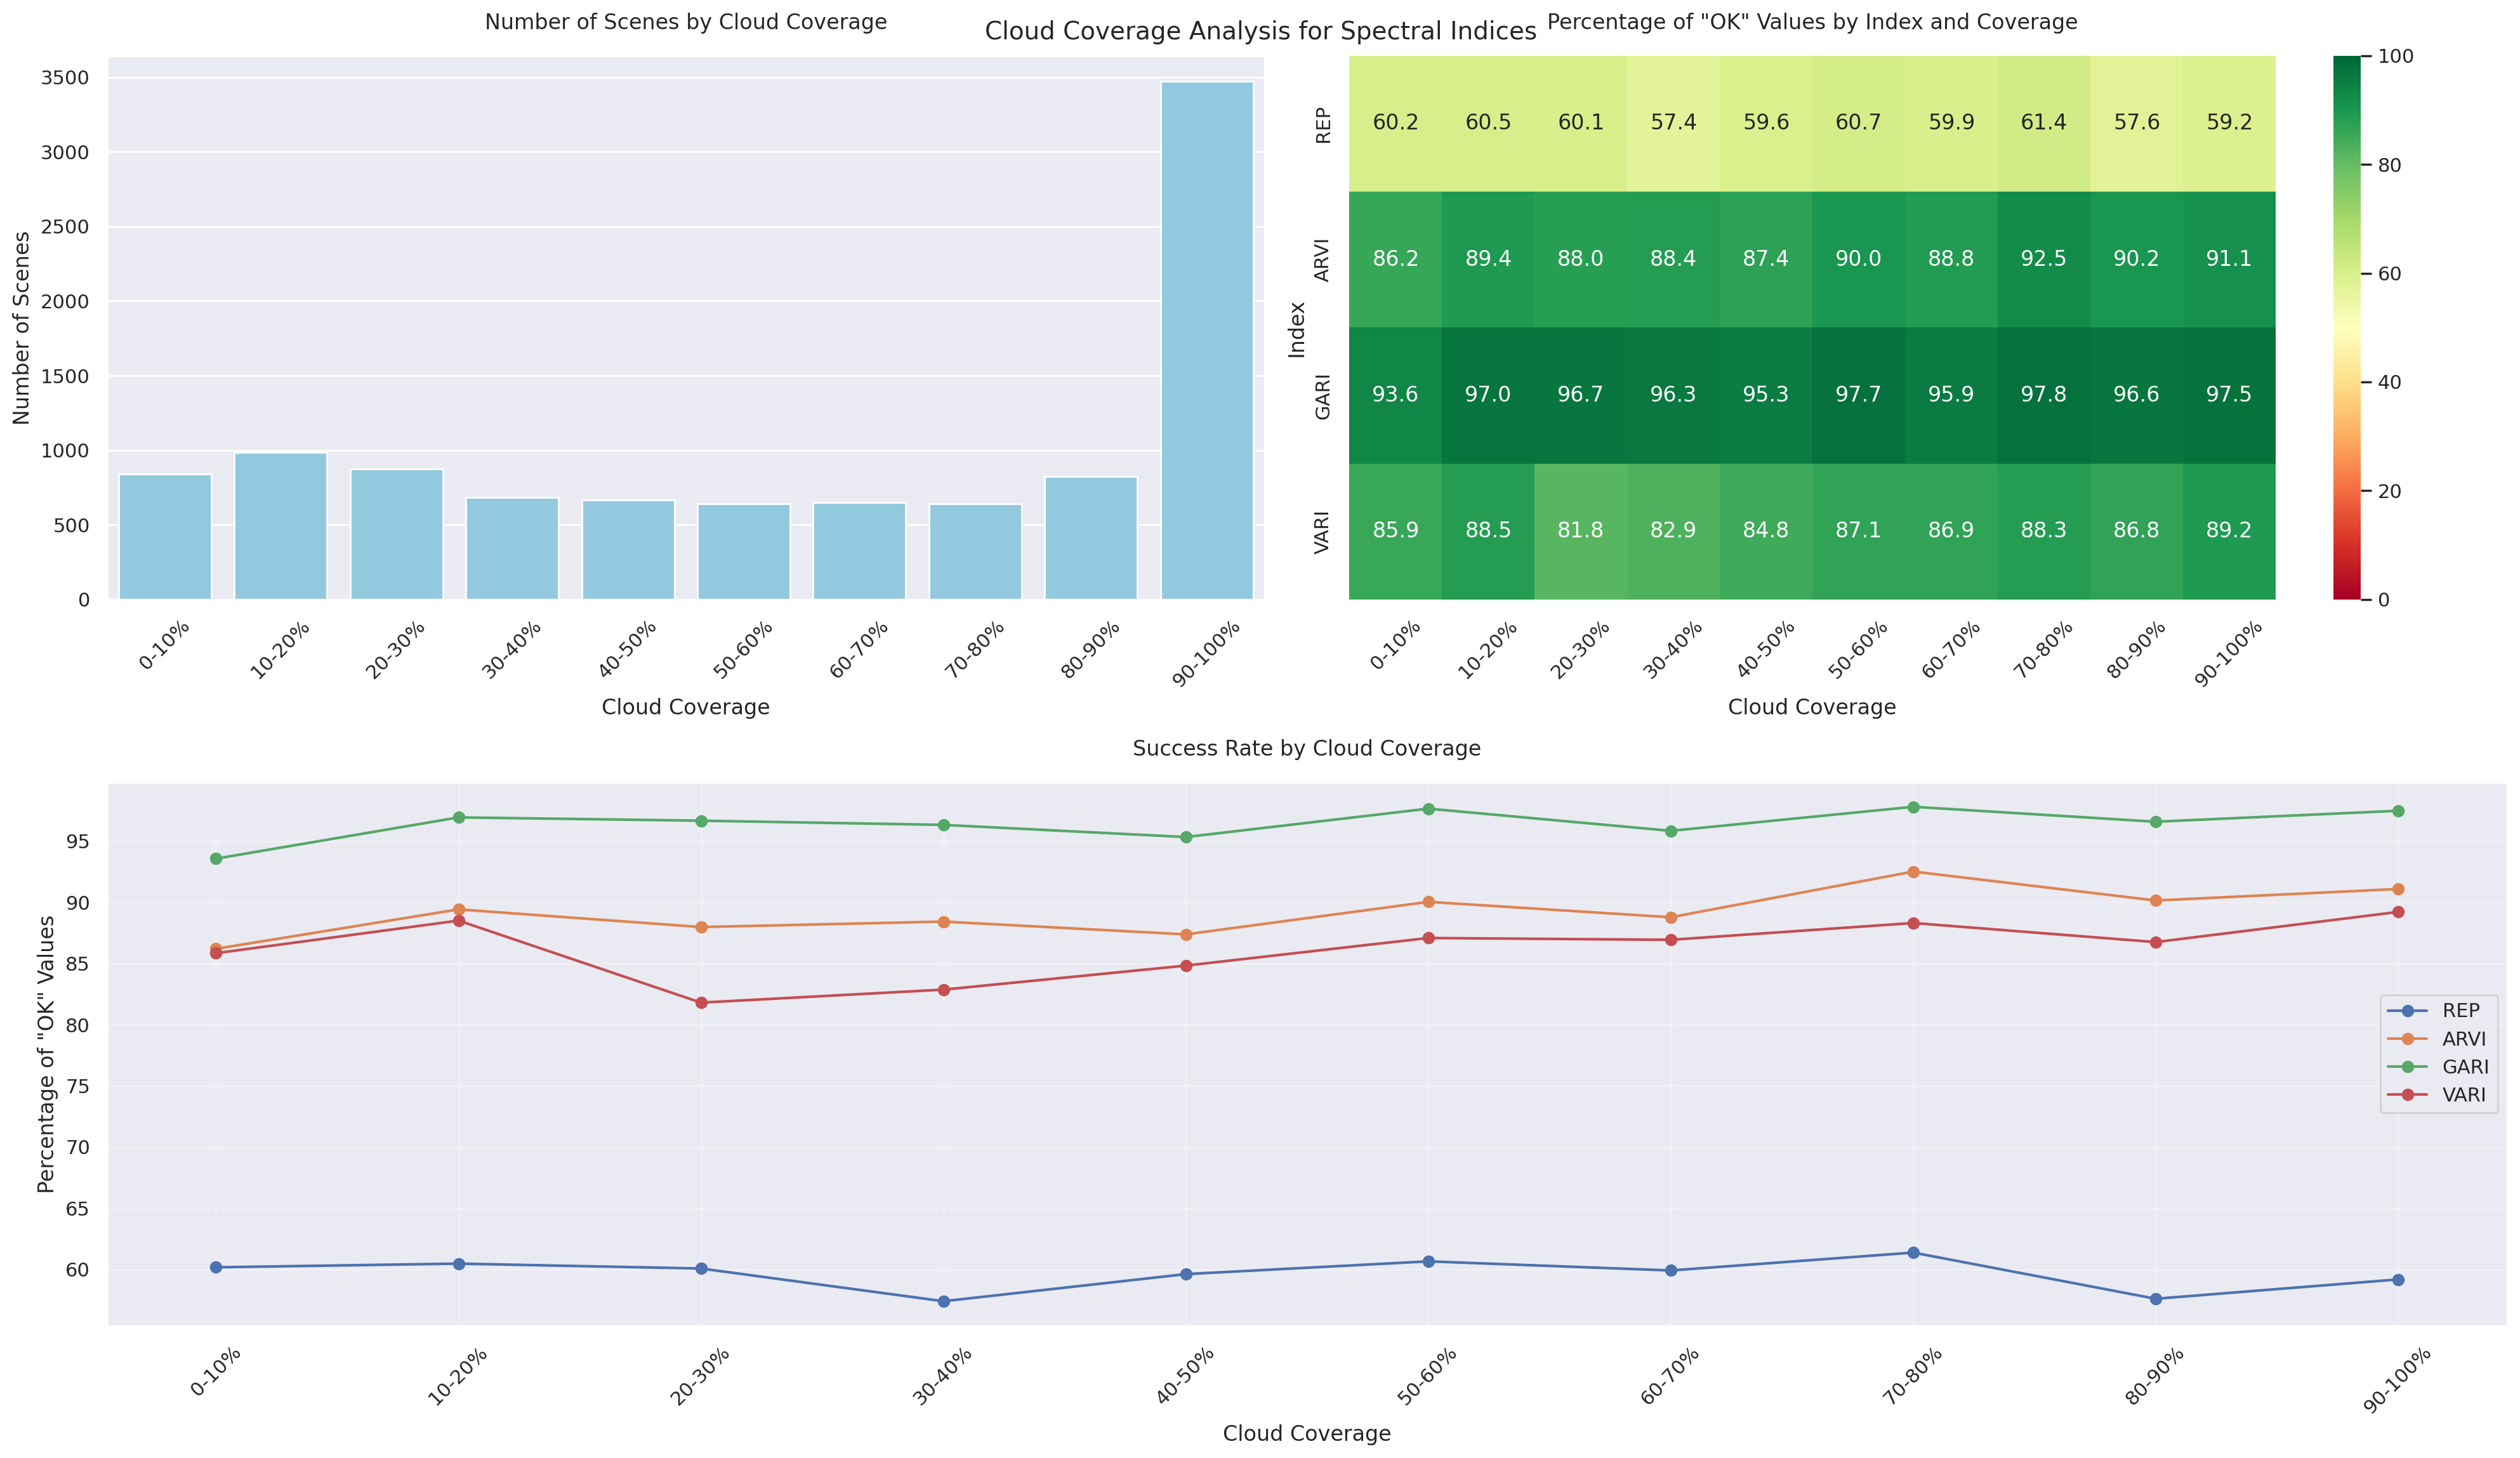


Summary Statistics:
--------------------------------------------------------------------------------
REP   total success rate: 59.5% (6117/10278 scenes)
ARVI  total success rate: 89.7% (9215/10278 scenes)
GARI  total success rate: 96.7% (9938/10278 scenes)
VARI  total success rate: 87.0% (8943/10278 scenes)


In [39]:
def plot_coverage_analysis(df_stats):    
    fig = plt.figure(figsize=(20, 12))
    
    ax1 = plt.subplot(2, 2, 1)
    sns.barplot(data=df_stats, x='CoverageBin', y='NumScenes', 
                color='skyblue', ax=ax1)
    ax1.set_title('Number of Scenes by Cloud Coverage', fontsize=12, pad=15)
    ax1.set_xlabel('Cloud Coverage')
    ax1.set_ylabel('Number of Scenes')
    ax1.tick_params(axis='x', rotation=45)
    
    ax2 = plt.subplot(2, 2, 2)

    heatmap_data = df_stats[[f"{idx}_OK_pct" for idx in problem_indices]].T
    heatmap_data.index = problem_indices
    heatmap_data.columns = df_stats['CoverageBin']
    
    sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap='RdYlGn',
                vmin=0, vmax=100, ax=ax2)
    ax2.set_title('Percentage of "OK" Values by Index and Coverage', fontsize=12, pad=15)
    ax2.set_xlabel('Cloud Coverage')
    ax2.set_ylabel('Index')
    ax2.tick_params(axis='x', rotation=45)
    
    ax3 = plt.subplot(2, 1, 2)
    for idx in problem_indices:
        ax3.plot(df_stats['CoverageBin'], 
                 df_stats[f"{idx}_OK_pct"], 
                 marker='o', 
                 label=idx)
    
    ax3.set_title('Success Rate by Cloud Coverage', fontsize=12, pad=15)
    ax3.set_xlabel('Cloud Coverage')
    ax3.set_ylabel('Percentage of "OK" Values')
    ax3.grid(True, alpha=0.3)
    ax3.legend()
    ax3.tick_params(axis='x', rotation=45)
    
    plt.suptitle('Cloud Coverage Analysis for Spectral Indices', 
                 fontsize=14, y=0.95)
    
    plt.tight_layout()
    plt.show()
    
    print("\nSummary Statistics:")
    print("-" * 80)
    total_scenes = df_stats["NumScenes"].sum()
    for idx in problem_indices:
        ok_total = df_stats[f"{idx}_OK_count"].sum()
        rate = 100.0 * ok_total / total_scenes if total_scenes>0 else 0
        print(f"{idx:5} total success rate: {rate:.1f}% ({ok_total}/{total_scenes} scenes)")

plot_coverage_analysis(df_stats)

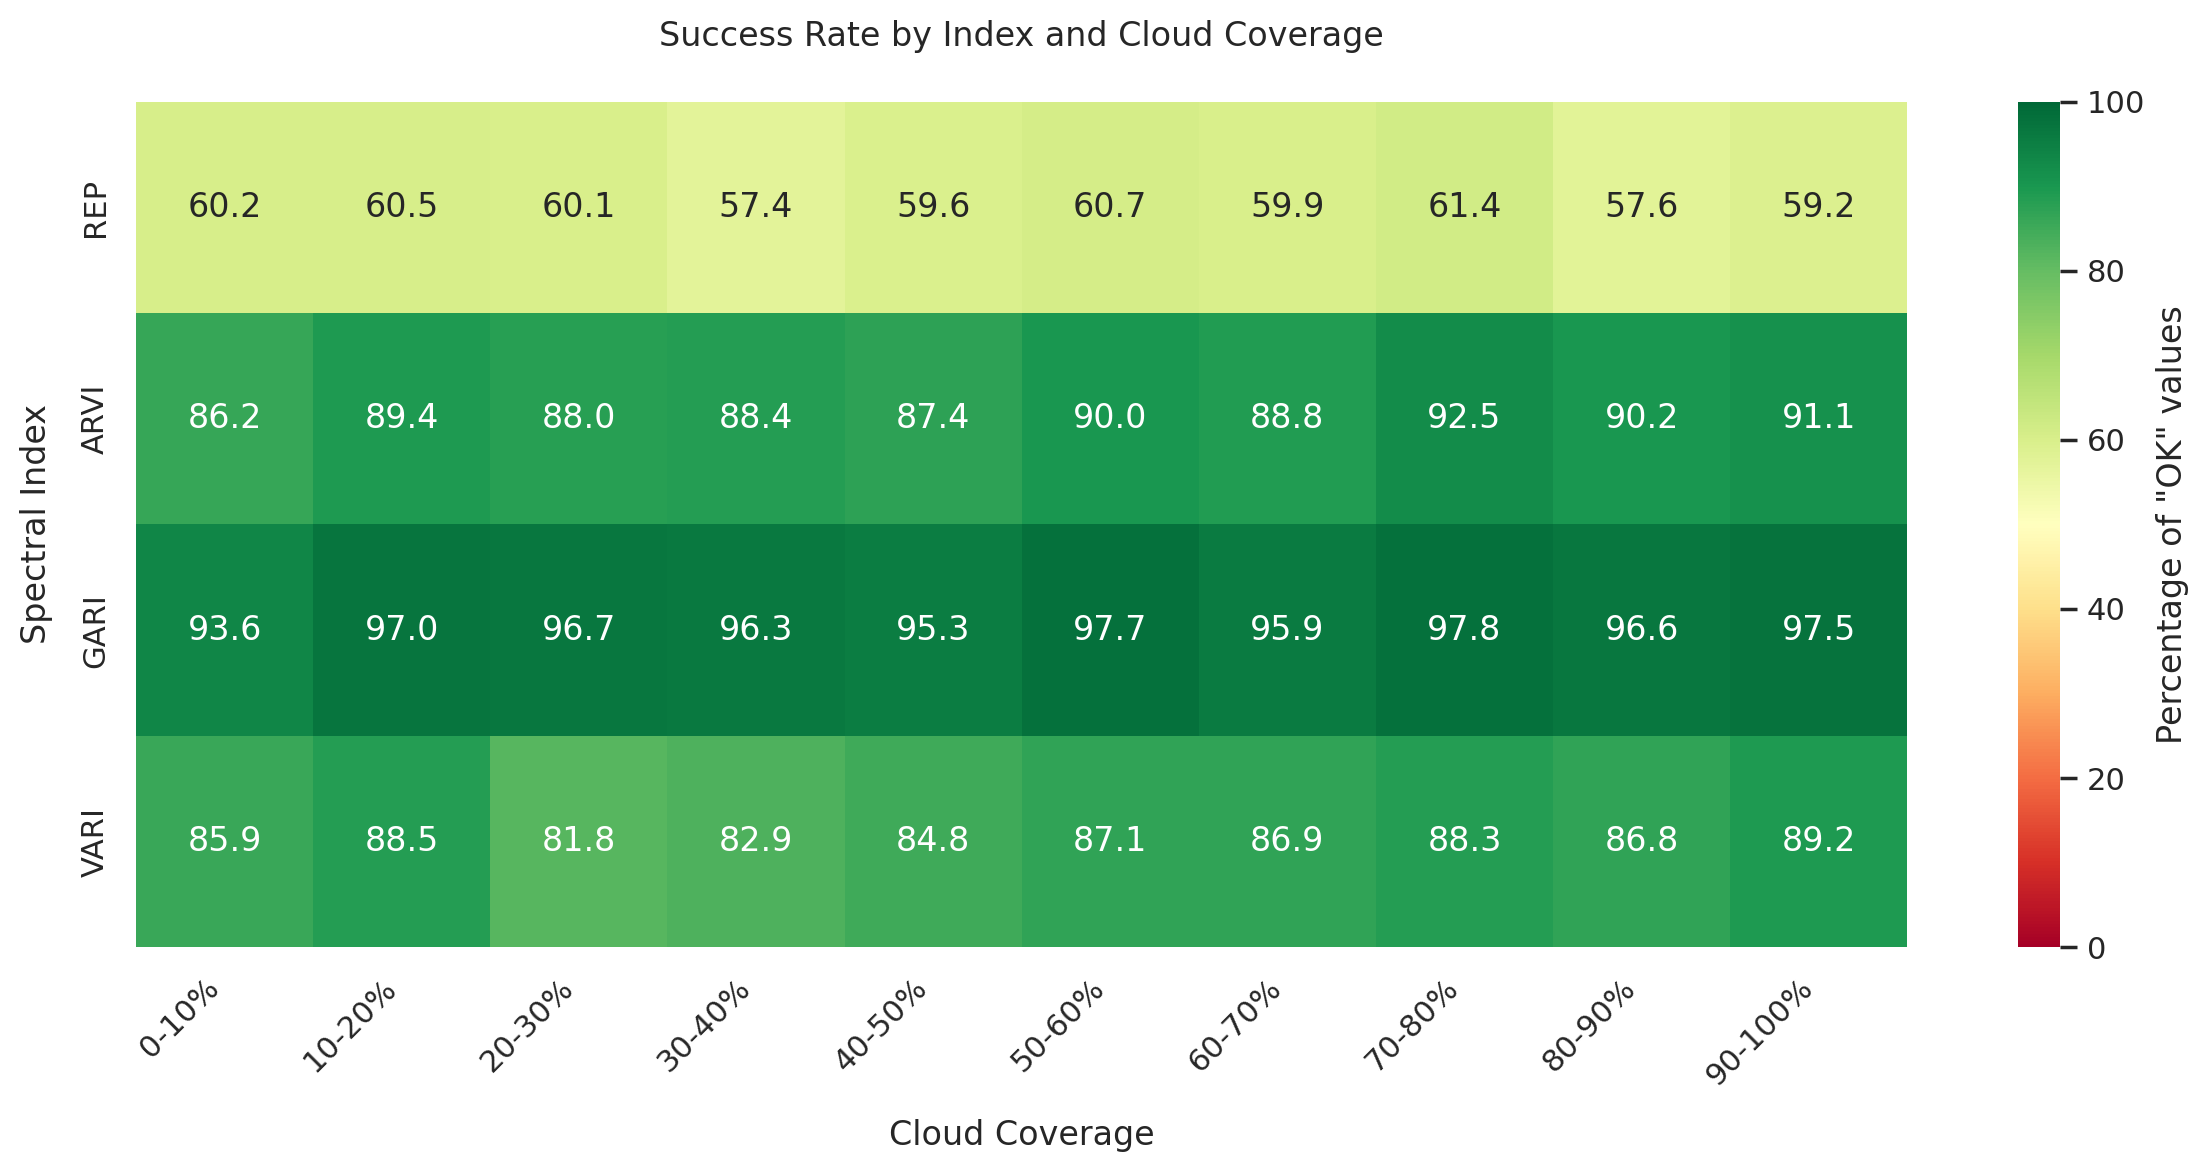

In [40]:
def plot_coverage_heatmap(df_stats):
    plt.figure(figsize=(12, 6))
    
    heatmap_data = df_stats[[f"{idx}_OK_pct" for idx in ["REP", "ARVI", "GARI", "VARI"]]].T
    heatmap_data.index = ["REP", "ARVI", "GARI", "VARI"]
    heatmap_data.columns = df_stats['CoverageBin']
    
    sns.heatmap(heatmap_data, 
                annot=True, 
                fmt='.1f',        
                cmap='RdYlGn',         
                vmin=0,            
                vmax=100,    
                cbar_kws={'label': 'Percentage of "OK" values'})
    
    plt.title('Success Rate by Index and Cloud Coverage', pad=20)
    plt.xlabel('Cloud Coverage', labelpad=10)
    plt.ylabel('Spectral Index', labelpad=10)
    
    plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    
    plt.show()

plot_coverage_heatmap(df_stats)

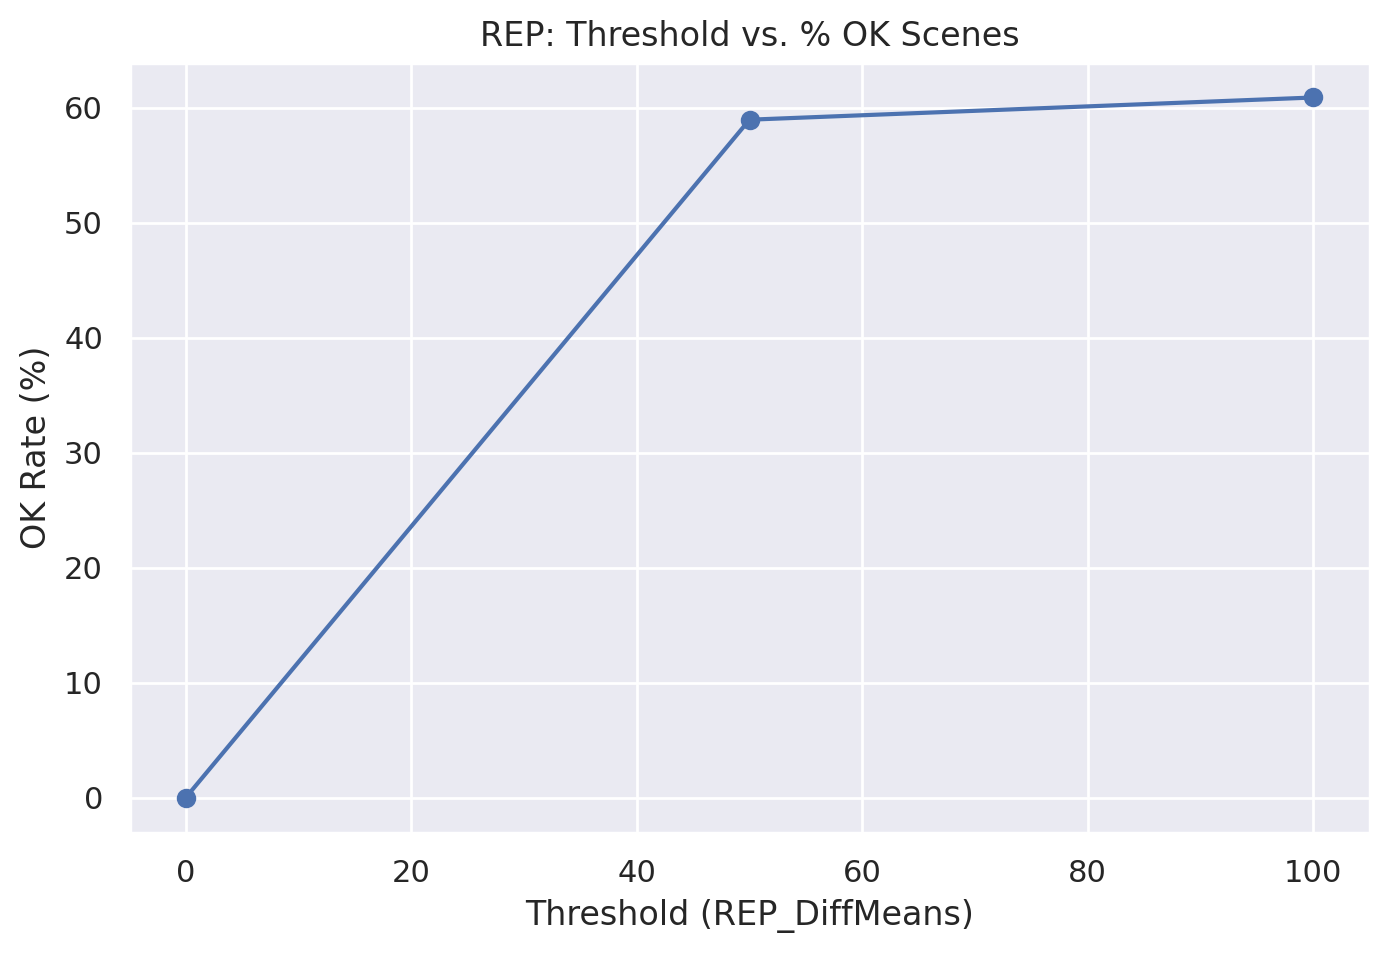

In [41]:
def get_ok_curve(df, col_diff, max_thr=5000, step=50):
    result_thr = []
    result_ok = []
    n_total = len(df)
    for T in np.arange(0, max_thr+step, step):
        n_ok = (df[col_diff] <= T).sum()
        frac_ok = n_ok / n_total
        result_thr.append(T)
        result_ok.append(frac_ok)
    return result_thr, result_ok

thr_values, ok_values = get_ok_curve(df, "REP_DiffMeans",
                                     max_thr=100, step=50)

plt.figure(figsize=(8,5))
plt.plot(thr_values, np.array(ok_values)*100, marker='o')
plt.xlabel("Threshold (REP_DiffMeans)")
plt.ylabel("OK Rate (%)")
plt.title("REP: Threshold vs. % OK Scenes")
plt.grid(True)
plt.show()

In [71]:
df["ROIs"] = df["filename"].str.split("_").str[0] 
df["season"] = df["filename"].str.split("_").str[1]

print(df[["filename", "ROIs", "season"]].head())

                   filename      ROIs  season
0  ROIs1158_spring_100_p165  ROIs1158  spring
1  ROIs1158_spring_100_p117  ROIs1158  spring
2  ROIs1158_spring_100_p140  ROIs1158  spring
3  ROIs1158_spring_100_p148  ROIs1158  spring
4  ROIs1158_spring_100_p138  ROIs1158  spring


In [73]:
df["Not_OK_Count"] = (~df[[f"{idx}_ok" for idx in problem_indices]]).sum(axis=1)

In [75]:
df_summary = df.groupby(["ROIs", "season"])["Not_OK_Count"].sum().reset_index()

df_summary = df_summary.rename(columns={"Not_OK_Count": "Total_Not_OK_Scenes"})

print(df_summary)

df_summary.to_csv("ROIs_season_not_ok_summary.csv", index=False)

       ROIs  season  Total_Not_OK_Scenes
0  ROIs1158  spring                 1175
1  ROIs1868  summer                 2005
2  ROIs1970    fall                 2829
3  ROIs2017  winter                 1126


In [78]:
df["AtLeastOne_Not_OK"] = ~df[[f"{idx}_ok" for idx in problem_indices]].all(axis=1)

total_scenes = len(df)

total_not_ok_scenes = df["AtLeastOne_Not_OK"].sum()

percentage_not_ok = (total_not_ok_scenes / total_scenes) * 100

print(f"Всего снимков: {total_scenes}")
print(f"Снимков с хотя бы одним 'не ОК' индексом: {total_not_ok_scenes}")
print(f"Процент 'не ОК' снимков: {percentage_not_ok:.2f}%")

Всего снимков: 10569
Снимков с хотя бы одним 'не ОК' индексом: 4989
Процент 'не ОК' снимков: 47.20%


In [77]:
total_not_ok_indices = (~df[[f"{idx}_ok" for idx in problem_indices]]).sum().sum()

print(f"Всего 'не ОК' индексов во всех сценах: {total_not_ok_indices}")

Всего 'не ОК' индексов во всех сценах: 7135


In [80]:
import pandas as pd

if 'filename' not in df.columns or 'REP_DiffMeans' not in df.columns:
    raise ValueError("DataFrame должен содержать столбцы 'filename' и 'REP_DiffMeans'.")

top10_worst_scenes_nlargest = df.nlargest(100, 'REP_DiffMeans')

print("Топ-10 сцен с наибольшим отклонением REP (метод nlargest):")
for idx, row in top10_worst_scenes_nlargest.iterrows():
    print(f"{idx + 1}. Файл: {row['filename']}, REP_DiffMeans: {row['REP_DiffMeans']:.2f}")

print("\n" + "-"*50 + "\n")

top10_worst_scenes_sorted = df.sort_values(by='REP_DiffMeans', ascending=False).head(100)

print("Топ-10 сцен с наибольшим отклонением REP (метод сортировки):")
for idx, row in top10_worst_scenes_sorted.iterrows():
    print(f"{idx + 1}. Файл: {row['filename']}, REP_DiffMeans: {row['REP_DiffMeans']:.2f}")

Топ-10 сцен с наибольшим отклонением REP (метод nlargest):
3202. Файл: ROIs1868_summer_125_p714, REP_DiffMeans: 478829.48
2600. Файл: ROIs1868_summer_113_p312, REP_DiffMeans: 478048.12
3175. Файл: ROIs1868_summer_125_p470, REP_DiffMeans: 397404.99
3182. Файл: ROIs1868_summer_125_p500, REP_DiffMeans: 387062.06
2603. Файл: ROIs1868_summer_113_p386, REP_DiffMeans: 386693.55
2594. Файл: ROIs1868_summer_113_p238, REP_DiffMeans: 382153.68
2604. Файл: ROIs1868_summer_113_p371, REP_DiffMeans: 374558.48
1624. Файл: ROIs1158_spring_26_p568, REP_DiffMeans: 359648.40
2587. Файл: ROIs1868_summer_113_p166, REP_DiffMeans: 357146.74
1616. Файл: ROIs1158_spring_26_p462, REP_DiffMeans: 351784.11
3184. Файл: ROIs1868_summer_125_p534, REP_DiffMeans: 351645.85
2596. Файл: ROIs1868_summer_113_p287, REP_DiffMeans: 349133.70
2591. Файл: ROIs1868_summer_113_p167, REP_DiffMeans: 336304.00
1629. Файл: ROIs1158_spring_26_p543, REP_DiffMeans: 327654.05
5074. Файл: ROIs1868_summer_7_p866, REP_DiffMeans: 318508.33
2

In [ ]:
import matplotlib.pyplot as plt
import rasterio

for idx, row in top10_worst_scenes_nlargest.iterrows():
    filename = row['filename']
    rep_diff = row['REP_DiffMeans']
    
    filepath_gt = f"./test_saved/{filename}_GT.tif"
    filepath_pred = f"./test_saved/{filename}_pred.tif"
    
    with rasterio.open(filepath_gt) as src_gt:
        gt_data = src_gt.read()
    with rasterio.open(filepath_pred) as src_pred:
        pred_data = src_pred.read()
    
    rep_gt = get_index("REP", gt_data)
    rep_pred = get_index("REP", pred_data)
    
    rep_diff_array = rep_pred - rep_gt
    
    plt.figure(figsize=(18, 6))
    
    plt.subplot(1, 3, 1)
    plt.title(f"{filename} - REP GT")
    plt.imshow(rep_gt, cmap='viridis')
    plt.colorbar()
    
    plt.subplot(1, 3, 2)
    plt.title(f"{filename} - REP Pred")
    plt.imshow(rep_pred, cmap='viridis')
    plt.colorbar()
    
    plt.subplot(1, 3, 3)
    plt.title(f"{filename} - REP Diff")
    plt.imshow(rep_diff_array, cmap='bwr', vmin=-500, vmax=500)
    plt.colorbar()
    
    plt.tight_layout()
    plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio

def normalize(array):
    """Нормализует массив в диапазон 0-1 для отображения в RGB."""
    array = np.clip(array, 0, 1)  # Ограничиваем значения от 0 до 1
    return (array - np.min(array)) / (np.max(array) - np.min(array) + 1e-8)

for idx, row in top10_worst_scenes_nlargest.iterrows():
    filename = row['filename']
    
    filepath_gt = f"./test_saved/{filename}_GT.tif"
    filepath_pred = f"./test_saved/{filename}_pred.tif"
    
    with rasterio.open(filepath_gt) as src_gt:
        gt_data = src_gt.read()  # (C, H, W)
    with rasterio.open(filepath_pred) as src_pred:
        pred_data = src_pred.read()  # (C, H, W)

    red_gt, green_gt, blue_gt = gt_data[3], gt_data[2], gt_data[1]  # B4, B3, B2
    red_pred, green_pred, blue_pred = pred_data[3], pred_data[2], pred_data[1]  # B4, B3, B2

    rgb_gt = np.stack([normalize(red_gt), normalize(green_gt), normalize(blue_gt)], axis=-1)
    rgb_pred = np.stack([normalize(red_pred), normalize(green_pred), normalize(blue_pred)], axis=-1)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.title(f"{filename} - RGB GT")
    plt.imshow(rgb_gt)
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title(f"{filename} - RGB Pred")
    plt.imshow(rgb_pred)
    plt.axis("off")

    plt.tight_layout()
    plt.show()

In [59]:
path_gt = os.path.join(test_saved_dir, filename_worst + "_GT.tif")
path_pred = os.path.join(test_saved_dir, filename_worst + "_pred.tif")
path_cloudy = os.path.join(test_saved_dir, filename_worst + "_cloudy.tif")

gt_data = read_tiff(path_gt).numpy()  # (13, H, W)
pred_data = read_tiff(path_pred).numpy()  # (13, H, W)
cloudy_data = read_tiff(path_cloudy).numpy()

print(f"Загружены изображения GT и Pred: {gt_data.shape}")

Загружены изображения GT и Pred: (13, 256, 256)


/opt/conda/lib/python3.10/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


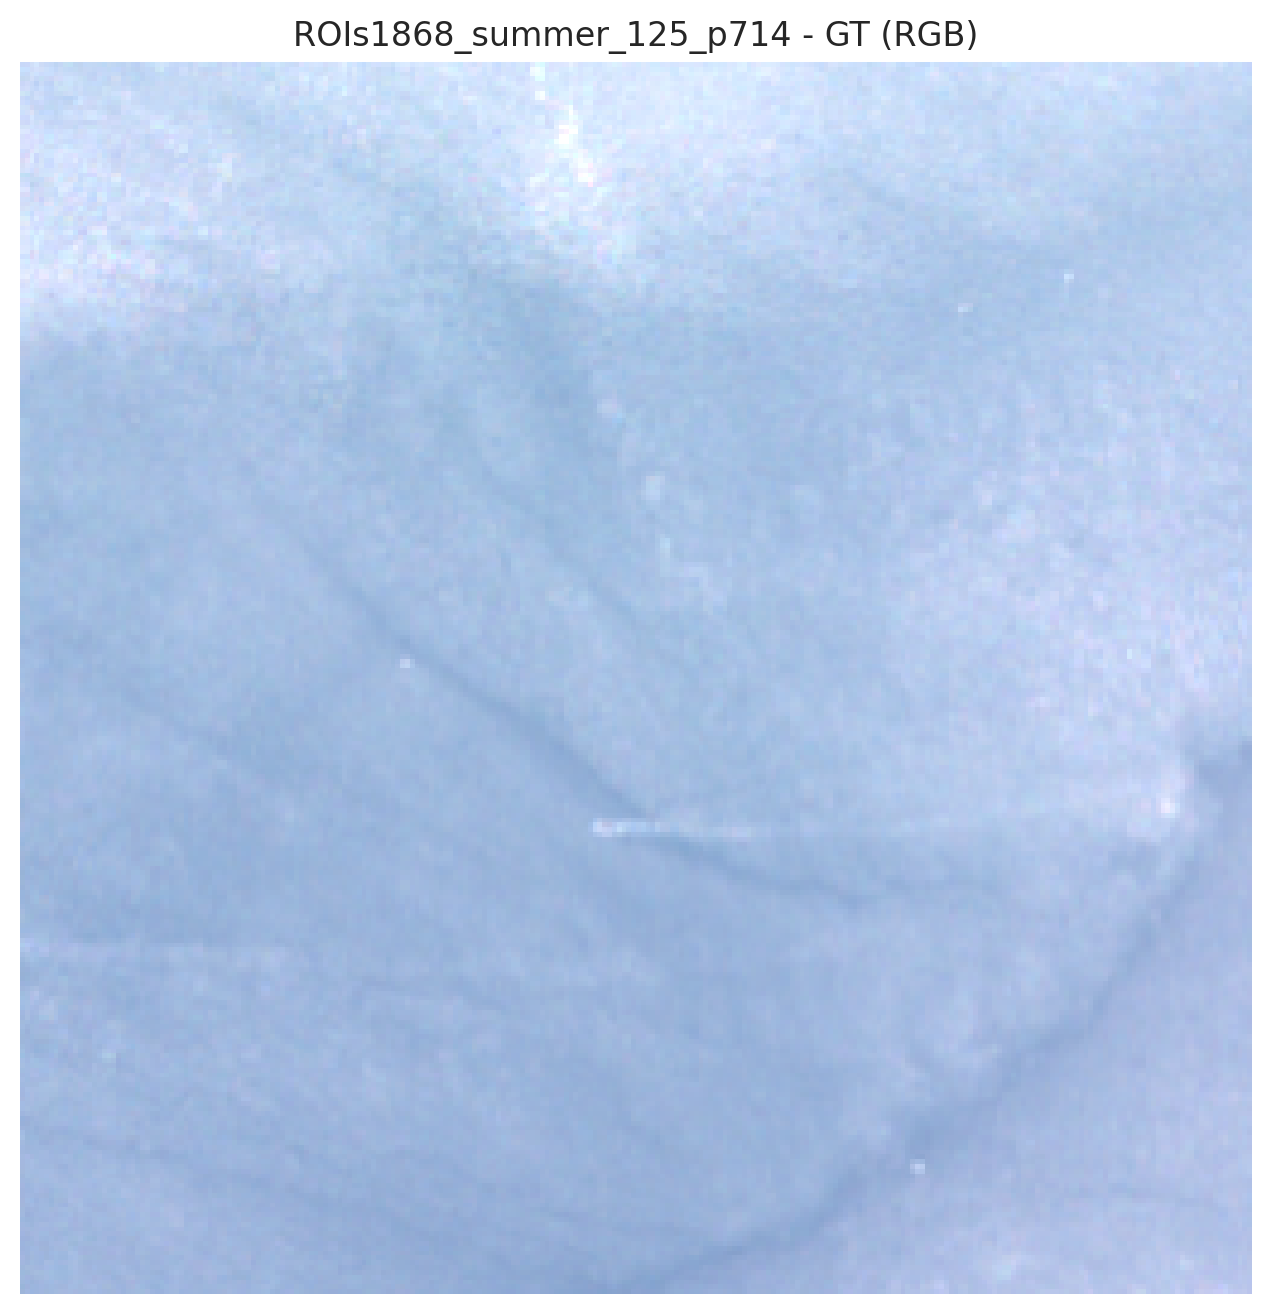

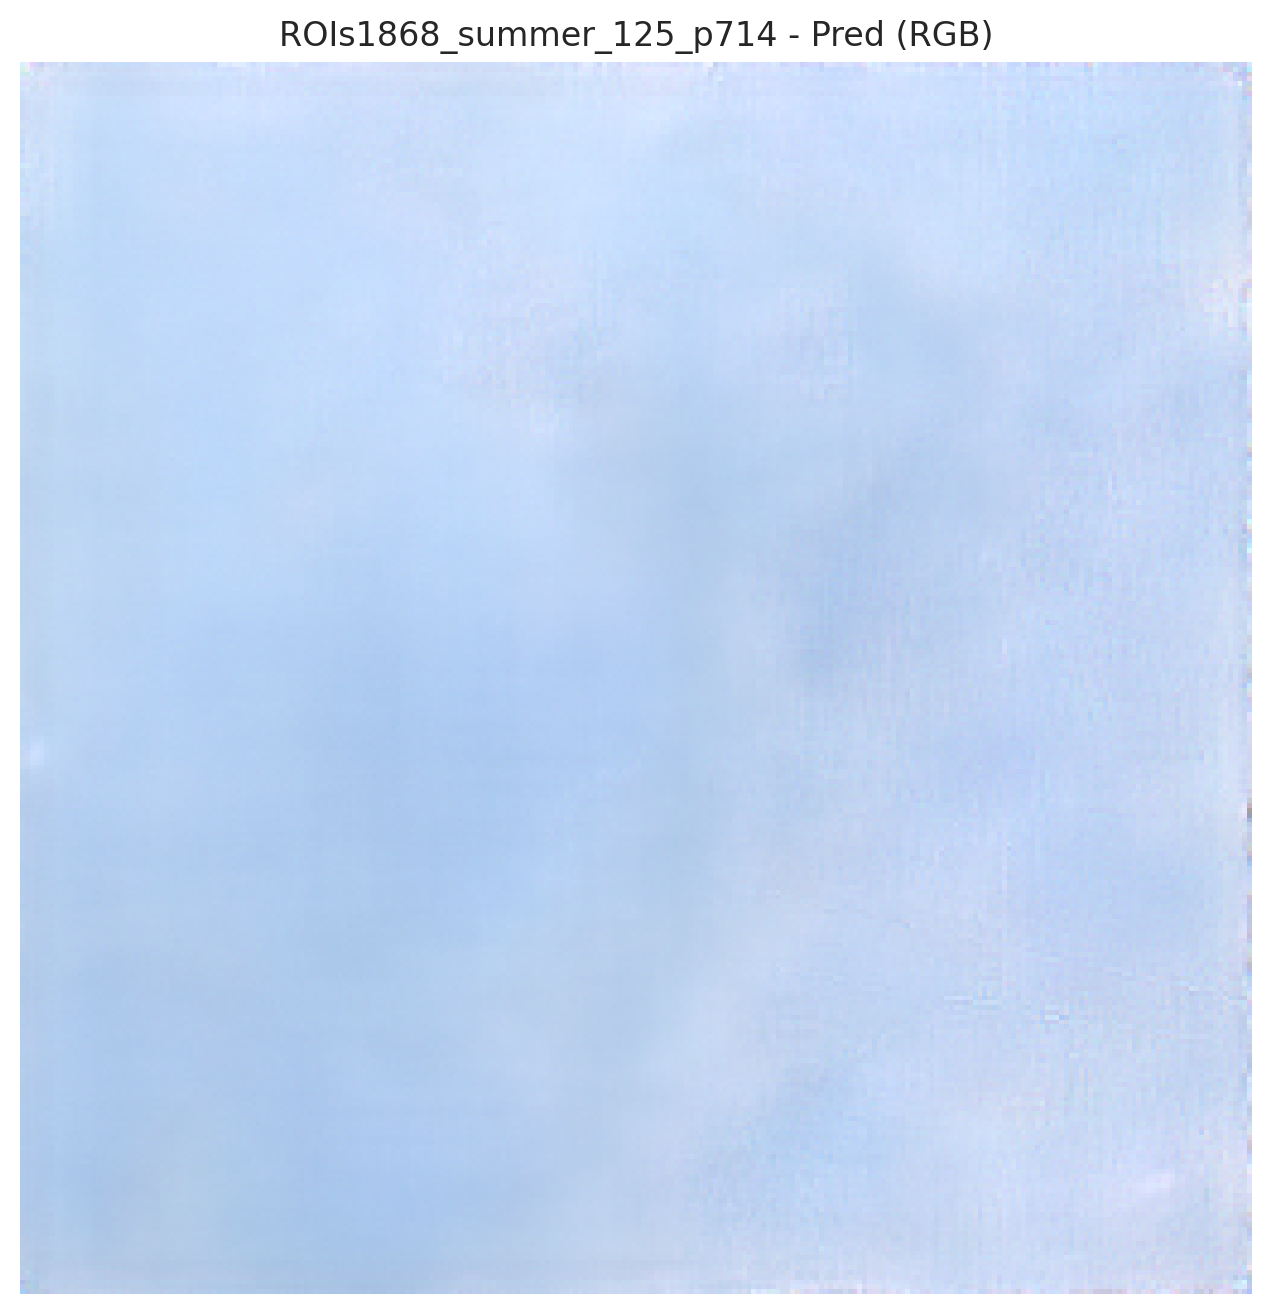

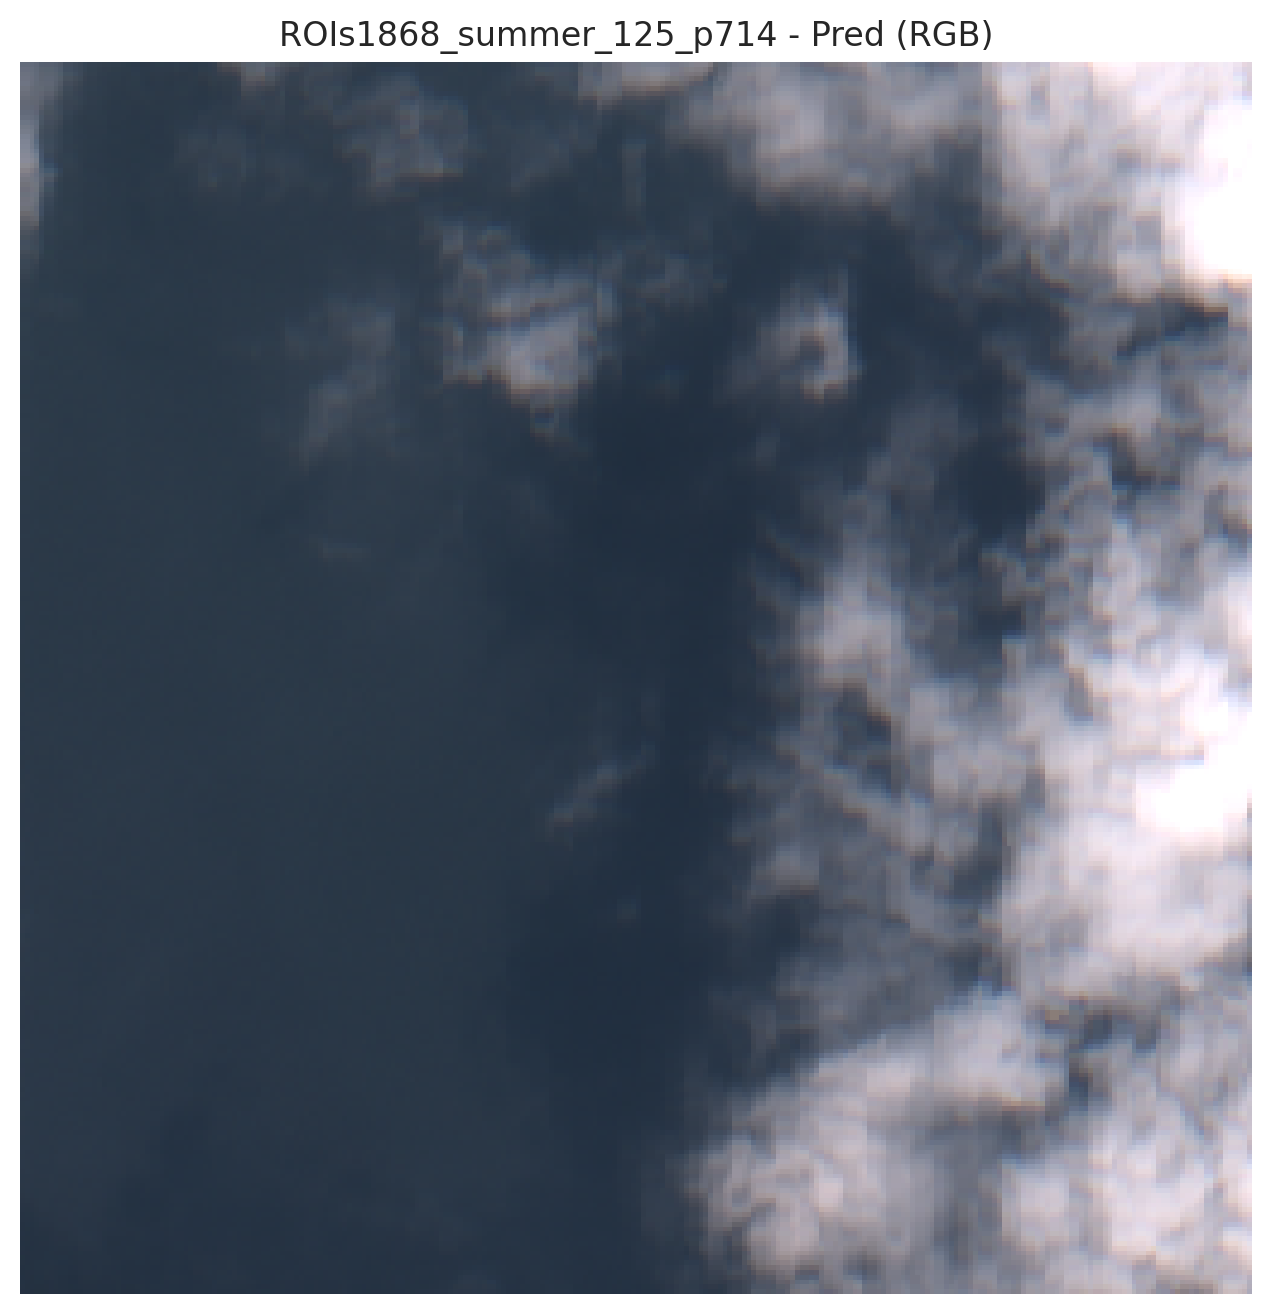

In [60]:
def plot_rgb(image, title="RGB Image", scale=0.3):
    """
    Отображаем изображение в RGB. Ожидает image в формате (C, H, W)
    Используем Sentinel-2 каналы: R = B4 (idx=3), G = B3 (idx=2), B = B2 (idx=1)
    """
    img_rgb = np.stack([image[3], image[2], image[1]], axis=-1)  # (H, W, 3)

    img_rgb = np.clip(img_rgb, 0, np.percentile(img_rgb, 99))  # Ограничиваем выбросы
    img_rgb = (img_rgb / img_rgb.max() * 255).astype(np.uint8)

    plt.figure(figsize=(8, 8))
    plt.imshow(img_rgb)
    plt.title(title)
    plt.axis("off")
    plt.show()

plot_rgb(gt_data, title=f"{filename_worst} - GT (RGB)")
plot_rgb(pred_data, title=f"{filename_worst} - Pred (RGB)")
plot_rgb(cloudy_data, title=f"{filename_worst} - Pred (RGB)")

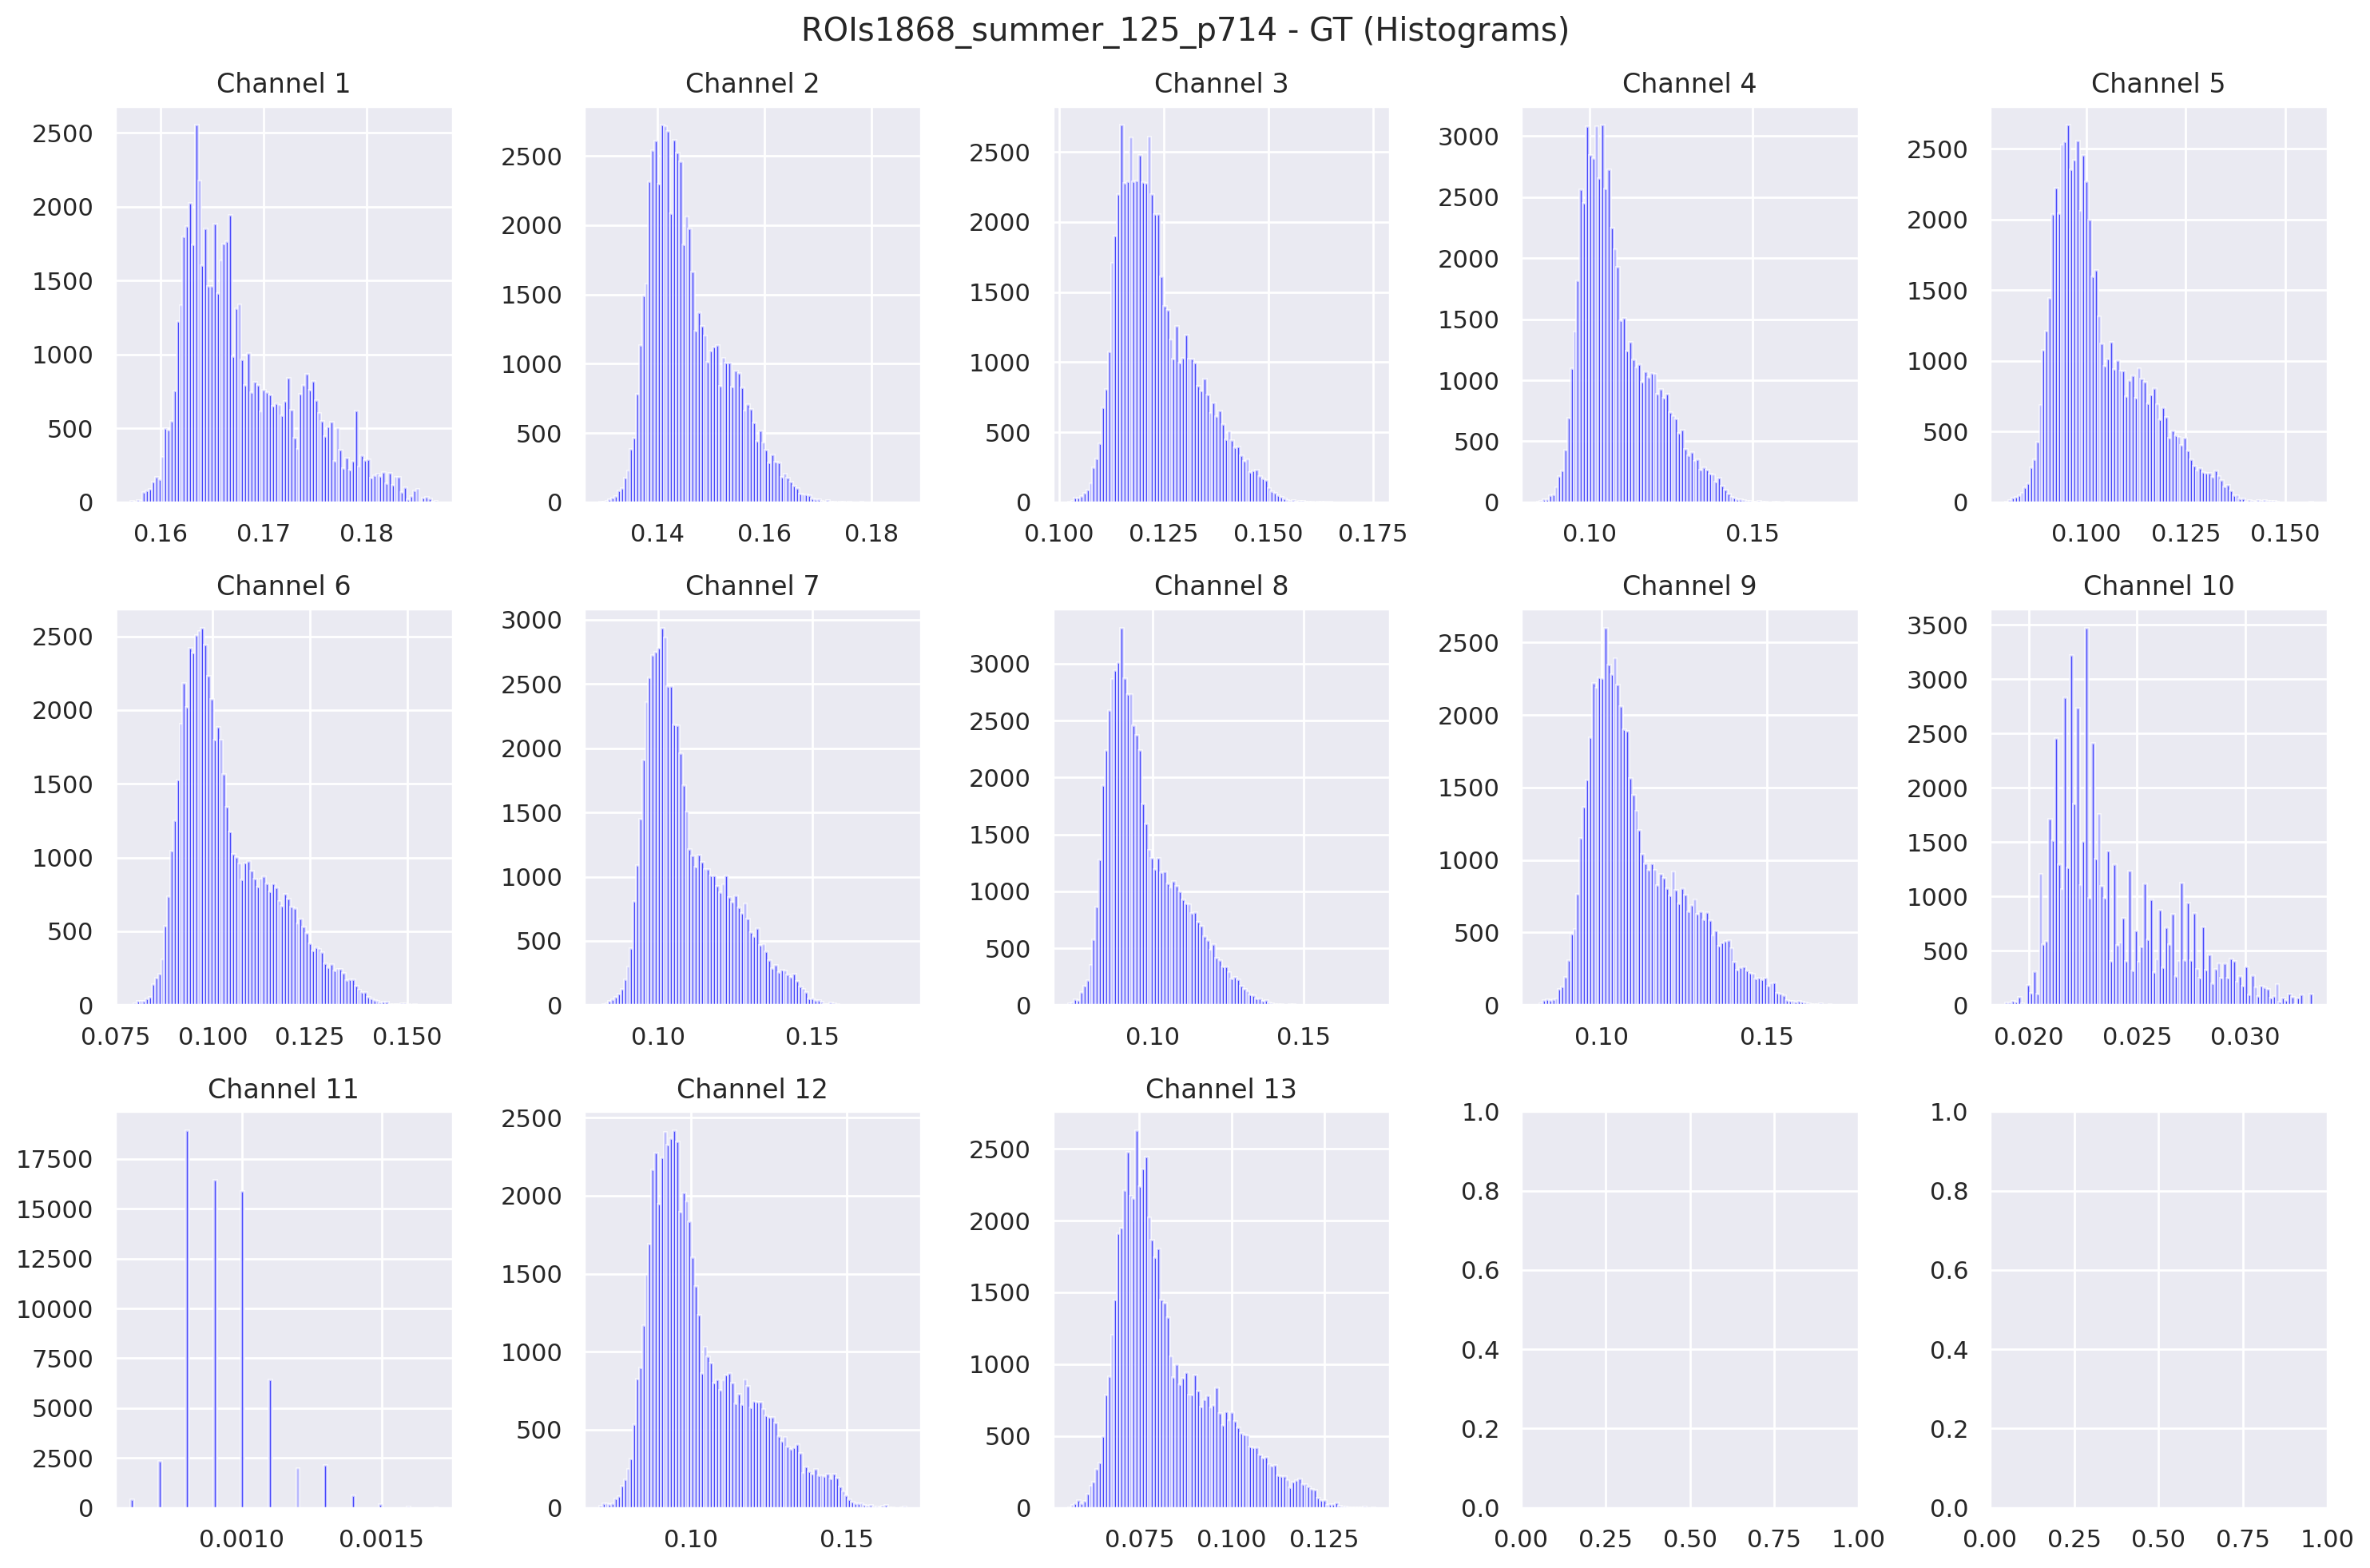

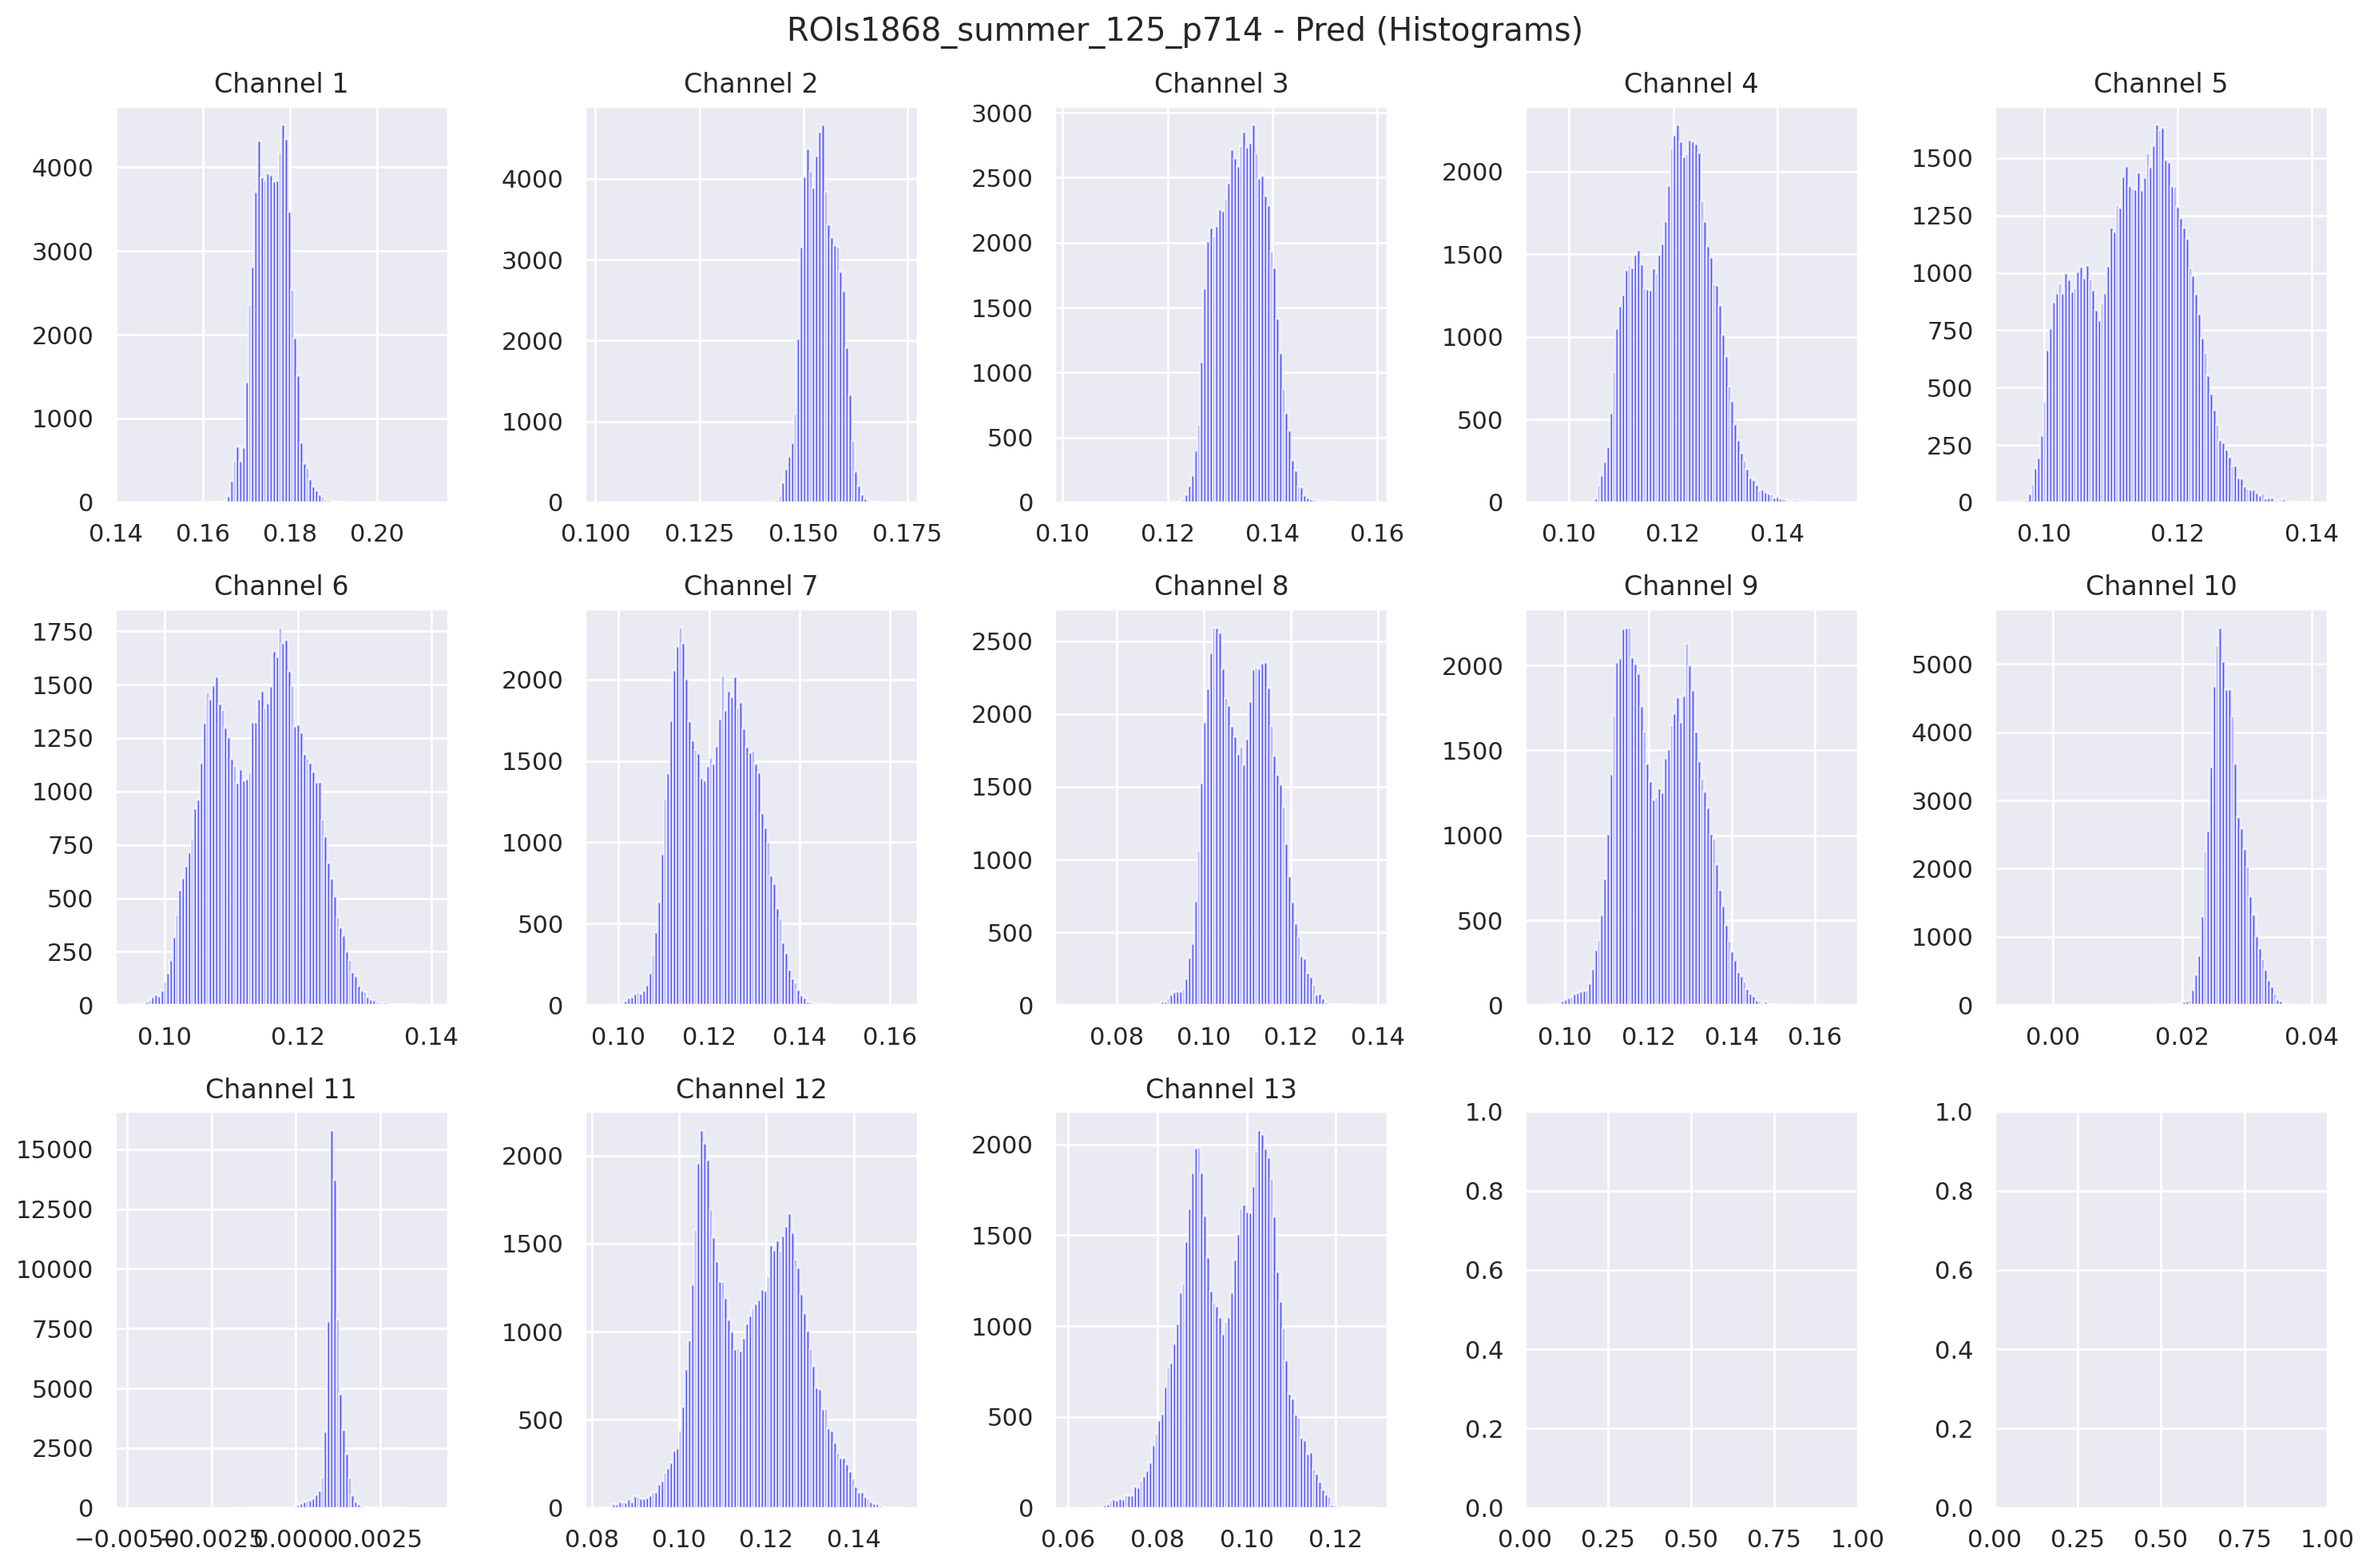

In [46]:
def plot_histograms(image, title="Histogram of Channels"):
    """
    Строит гистограммы для всех 13 каналов изображения.
    image: тензор (13, H, W)
    """
    fig, axes = plt.subplots(3, 5, figsize=(15, 10))
    axes = axes.flatten()
    
    for i in range(13):
        ax = axes[i]
        channel_data = image[i].flatten()
        ax.hist(channel_data, bins=100, color='blue', alpha=0.7)
        ax.set_title(f"Channel {i+1}")
        ax.grid(True)

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

plot_histograms(gt_data, title=f"{filename_worst} - GT (Histograms)")
plot_histograms(pred_data, title=f"{filename_worst} - Pred (Histograms)")

In [47]:
mean_gt = gt_data.mean(axis=(1,2))
mean_pred = pred_data.mean(axis=(1,2))

df_means = pd.DataFrame({"Channel": range(1, 14),
                         "GT Mean": mean_gt,
                         "Pred Mean": mean_pred})
print(df_means)

    Channel   GT Mean  Pred Mean
0         1  0.168156   0.175961
1         2  0.145869   0.154281
2         3  0.123521   0.134285
3         4  0.108671   0.120371
4         5  0.103192   0.113492
5         6  0.104135   0.114172
6         7  0.109524   0.121451
7         8  0.097263   0.108989
8         9  0.111136   0.122779
9        10  0.023979   0.026911
10       11  0.000935   0.001122
11       12  0.103285   0.116521
12       13  0.083037   0.096317


In [52]:
!pip install ace-tools

In [61]:
import pandas as pd

def compute_channel_ranges(gt_data, pred_data):
    """
    Вычисляет минимальные и максимальные значения для каждого канала
    в эталонных (GT) и предсказанных (Pred) данных.
    """
    # Проверяем, что данные загружены
    if gt_data is None or pred_data is None:
        print("Ошибка: gt_data или pred_data не загружены!")
        return None

    # Вычисляем min/max значений по каждому каналу
    min_gt = gt_data.min(dim=(1,2)).cpu().numpy()
    max_gt = gt_data.max(dim=(1,2)).cpu().numpy()

    min_pred = pred_data.min(dim=(1,2)).cpu().numpy()
    max_pred = pred_data.max(dim=(1,2)).cpu().numpy()

    # Создаем DataFrame
    df_ranges = pd.DataFrame({
        "Channel": range(1, 14),
        "GT Min": min_gt,
        "GT Max": max_gt,
        "Pred Min": min_pred,
        "Pred Max": max_pred
    })

    return df_ranges

# Вызываем функцию для одной из сцен
scene_id = 0  # можно поменять на нужный индекс
df_ranges = compute_channel_ranges(gt_data_list[scene_id], pred_data_list[scene_id])

# Вывод результатов
if df_ranges is not None:
    print(df_ranges.to_string(index=False))

NameError: name 'gt_data_list' is not defined